In [1]:
import os
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
import numpy as np
np.corrcoef(range(10), range(10))
# import javabridge

array([[1., 1.],
       [1., 1.]])

In [2]:
import bioformats as bf
bf.javabridge.start_vm(class_path=bf.JARS, max_heap_size="6G")
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2
# %aimport islets

In [3]:
from islets.Recording import Recording

In [2]:
from islets.Regions import Regions
from islets.numeric import power_spectrum, rebin
from islets.utils import show_movie, saveRois

from islets.Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph

from caiman import movie as cmovie

from matplotlib.colors import LogNorm

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/tljh/user/envs/physio/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/tljh/user/envs/physio/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/tljh/user/envs/physio/lib/python3.7/site-packages/tensorflow/pyth

In [3]:
def get_filterSizes(px):
    base = int(np.ceil(5/px))
    wider = int(np.ceil(base*1.1))
    if wider==base: wider += 1
    toComb = int(np.ceil(base*1.3))
    if toComb <= wider: toComb += 1
    return [(base,), (wider,), (base,wider), (base,toComb)]

In [4]:
def parse_leica(rec):
    from pandas import Timedelta
    toDrop = [i for i,row in rec.metadata.iterrows() if "Series" not in row["Name"]]
    rec.metadata.drop(index=toDrop, inplace=True)
    if len(rec.metadata)>1:
        rec.calc_gaps()
        ff = np.any(
                [rec.metadata["gap"]>Timedelta("5s")]+
                [rec.metadata[c].diff().abs()>0 for c in ["pxSize", "SizeX", "SizeY"]],
            axis=0)
        sers = np.split(rec.metadata.Name.values, np.where(ff)[0])
    else:
        sers = [rec.metadata.Name.values]
    
    outSer = []
    for serlist in sers:
        if len(serlist)==len(rec.metadata):
            ser="all"
        else:
            serrange = [int(el.replace("Series","")) for el in serlist]
            if len(serrange)>1:
                ser = "Series%03i-%i"%(serrange[0],serrange[-1])
            else:
                ser = "Series%03i"%(serrange[0])
        outSer += [ser]
    return outSer

In [5]:
fracSaturTh = .05
movieFreq = 5
cmap = plt.cm.Greys
cmap.set_bad("lime")

In [5]:
folder = "/data/Sandra/2020/2020_06_22/"

In [10]:
for ndfile in os.listdir(folder):
    if ndfile.endswith("nd2"):
        pathToRecording = folder+ndfile


    rec = Recording(pathToRecording)
    recType = "Nikon" if pathToRecording.endswith(".nd2") else "Leica"

    if recType=="Leica":
        sers = parse_leica(rec)
    else:
        sers = ["all"]

    for ser in sers:
        saveDir = os.path.join(rec.folder, rec.Experiment+"_analysis", ser)
        if not os.path.isdir(saveDir):
            os.makedirs(saveDir)
        saveFilenameTemplate = os.path.join(saveDir, rec.Experiment+"_"+ser)

        # import data
        rec.import_series(ser)

        metadata = rec.Series[ser]["metadata"]
        movie = cmovie(rec.Series[ser]["data"],fr=metadata["Frequency"])

        movieFilename = saveFilenameTemplate+".mp4"
        if not os.path.isfile(movieFilename):
            if movieFreq<movie.fr:
                showMovie = movie.resize(1,1,movieFreq/movie.fr)
                frameRate = 30
            else:
                showMovie = movie
                frameRate = 30*movie.fr/movieFreq
            show_movie(showMovie, 
                   fps=frameRate,
                   NTimeFrames=len(showMovie),
                   out="save",
                   saveName=saveFilenameTemplate+".mp4"
                  )
            del showMovie
        # anull saturated above threshold
        Nsatur = (movie==movie.max()).sum(0)
        toAnull = np.where(Nsatur>len(movie)*fracSaturTh)
        movie[(slice(None), )+toAnull] = 0

        # go thorugh filter sizes
        regions = Regions(movie, full=False, diag=True, debleach=False)
        filtSizes = get_filterSizes(metadata.pxSize)

        for spFilt in filtSizes:
            pickleFile = os.path.join(saveDir, ".".join(map(str,spFilt))+"_rois.pkl")
        #     if os.path.isfile(pickleFile) and os.path.getsize(pickleFile)>100:
        #         continue
        #     else:
        #         print ("processing with filter size of ", spFilt)
            regions.constructRois(gSig_filt=spFilt,img_th=0)
            regions.update()
            while True:
                peak2bnd = getPeak2BoundaryDF(regions.df)
                df = peak2bnd.query("dist<1.")[["i","j"]]
                if len(df)==0: break
                gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
                dropped = mergeBasedOnGraph(gRois,regions)
                if dropped == 0: break

            regions.purge_lones((min(spFilt)*.4)**2)
            regions.sortFromCenter()
            saveRois(regions, saveDir, filename= ".".join(map(str,spFilt)), add_date=False, formats=["vienna"])

            fig = plt.figure(figsize=(5,5*np.divide(*movie.shape[1:])))
            ax = fig.add_axes([0.01,0.01,.98,.98])
            regions.plotEdges(imkw_args={"cmap":cmap},color="darkred", ax = ax)
            fig.savefig(os.path.join(saveDir, ".image_"+".".join(map(str,spFilt))+'.png'),dpi=150)
            plt.close(fig)

        del rec.Series[ser], regions, movie

Recording not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... more than two attractors, not implemented yet, will skip
150 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
4 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
7 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
1 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
0 subsumed into existing ROIs.
deleted 15 rois. 263 remain.
vienna
118 subsumed into existing ROIs.
7 subsumed into existing ROIs.
deleted 10 rois. 188 remain.
vienna
more than two attractors, not implemented yet, will skip
119 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
3 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
0 subsumed into existing ROIs.
3 subsumed into existing ROIs.
deleted 14 rois. 198 r

more than two attractors, not implemented yet, will skip
8 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
0 subsumed into existing ROIs.
deleted 19 rois. 219 remain.
vienna
Recording not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... Finished.
118 subsumed into existing ROIs.
3 subsumed into existing ROIs.
deleted 12 rois. 236 remain.
vienna
108 subsumed into existing ROIs.
1 subsumed into existing ROIs.
deleted 11 rois. 183 remain.
vienna
89 subsumed into existing ROIs.
deleted 10 rois. 200 remain.
vienna
125 subsumed into existing ROIs.
2 subsumed into existing ROIs.
deleted 9 rois. 191 remain.
vienna
Recording not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... Finished.
221 subsumed into existing ROIs.
9 subsumed into existing ROIs.
deleted 18 rois. 240 remain.
vienna
146 subsumed into existing ROIs.
3 subsumed into existing ROIs.
deleted 6 rois. 181 remain.
vie

In [12]:
rec.

dict_keys([])

In [1]:
import matplotlib

In [5]:
matplotlib.font_manager

AttributeError: module 'matplotlib' has no attribute 'font_manager'

In [4]:
matplotlib.get_cachedir()

'/home/jupyter-srdjan/.cache/matplotlib'

In [25]:
import cv2

In [26]:
writer = cv2.VideoWriter("output.avi",
cv2.VideoWriter_fourcc(*"MJPG"), 30, (640,480))

for frame in range(100):
    writer.write(np.random.randint(0, 255, (480,640,3)).astype('uint8'))

writer.release()

In [46]:
writer = cv2.VideoWriter("output.mp4",
cv2.VideoWriter_fourcc(*"H264"), 1, (2*9,2*9),isColor=False)

for frame in range(10000):
    writer.write(np.random.randint(0, 255, (2*9,2*9)).astype('uint8'))

writer.release()

In [17]:
regions = Regions(movie, full=False)

In [26]:
Nsatur = np.sum(movie == movie.max(),0)

In [28]:
# Nsatur

In [29]:
from matplotlib.colors import LogNorm

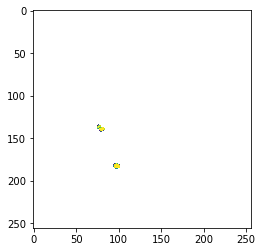

In [30]:
plt.imshow(Nsatur, norm=LogNorm())

In [35]:
regions.constructRois(gSig_filt=(6,5,))

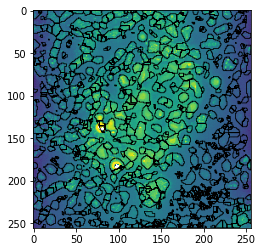

In [36]:
regions.plotEdges()

In [72]:
regions.statImages = sd

In [73]:
regions.constructRois(gSig_filt=4)

NameError: name 'multi_map' is not defined

In [5]:
rec = Recording("local_data/prototype/Experiment38b.lif")

In [6]:
ser = "Series041"
rec.import_series(ser)

In [7]:
data = rec.Series[ser]["data"]
meanImage = data.mean(0)
regions = Regions(meanImage, gSig_filt=(2,))
metadata = rec.Series[ser]["metadata"]
freq = metadata["Frequency"]

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.



### Power Spectrum

In [23]:
n = 1#int(freq/.03)
modFreq = []
for i in regions.df.index:
    point = regions.df.loc[i,"peak"]
    x = data[:,point[0],point[1]]
    f,p = power_spectrum(x, fr=freq)
    f,p = f[f>.5],np.abs(p[f>.5])
    if n>1:
        f = rebin(f,n)
        p = rebin(p,n)
    regions.df.loc[i,"peakFreq"] = f[np.argmax(p)]
    regions.df.loc[i,"peakProminence"] = np.max(p)

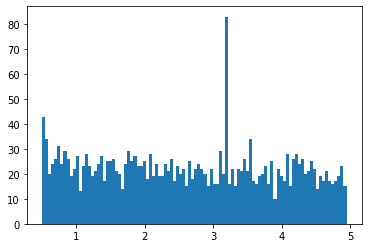

In [44]:
c,f = plt.hist(regions.df.peakFreq,100)[:2];

In [25]:
points = np.vstack(regions.df.sort_values("peakProminence",ascending=False).peak[:])

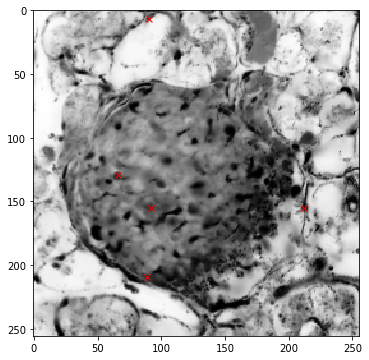

In [26]:
plt.figure(figsize=(6,6))
plt.imshow(np.log(meanImage+np.percentile(meanImage,1)), cmap="Greys")
plt.plot(*points[:5].T[::-1],ls="none",marker="x",c="r")

In [27]:
time = np.arange(len(x))/freq

In [28]:
from numeric import sosFilter

155 212


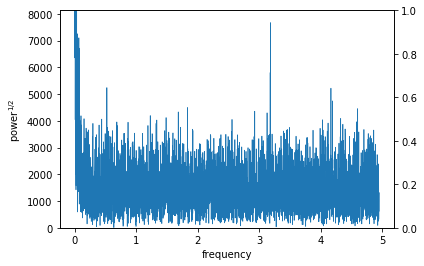

In [29]:
ipx = 0
print (points[ipx,0],points[ipx,1])
x = data[:,points[ipx,0],points[ipx,1]][:10000]
n = 1

for df in [0,-5,+5][:1]:
    ax = plt.subplot(111)
    bx = ax.twinx()

    f,p = power_spectrum(x, fr=freq)
#     f,p = f[f>.1],np.abs(p[f>.1])
    p = np.abs(p)
    f = rebin(f,n)
    p = rebin(p,n)
    ax.plot(f,p,lw=.7)
    ax.set_xlabel("frequency")
    ax.set_ylabel(r"power${}^{1/2}$")
    fpeak = f[f>.5][np.argmax(p[f>.5])]
    ax.set_ylim(0,p[f==fpeak][0]*1.06)
    fpeak += df
#     ax.axvline(fpeak, color="red", zorder=-1)

#     bx.plot([])
#     sbelow = sosFilter(fpeak-1,frequency=freq, order=20)
#     sabove = sosFilter(fpeak+1,frequency=freq, order=20)
# #     for sf in [sbelow, sabove]:
# #         bx.plot(*sf.get_shape())
#     xbelow = sbelow.run(x)
#     xabove = x-sabove.run(x)
#     xrest = x-xabove-xbelow
# #     for xx in [xbelow, xabove, xbelow+xabove]:
#     f,p = power_spectrum(xrest, fr=freq)
#     f,p = f[f>1],np.abs(p[f>1])
#     f = rebin(f,n)
#     p = rebin(p,n)
#     ax.plot(f,p,lw=.3)

    
#     fig, axs = plt.subplots(4,1,figsize=(15,10), sharey=True)
#     for i,ax in enumerate(axs):
# #         part = slice(int(len(x)*((i+1)*.1)), int(len(x)*((i+1)*.2+.1)))
#         part = slice(0,len(x)//(i+1)**2)
#         ax.plot(time[part], xrest[part])
# #         ax.plot(time[part], x[part],"-")
#     plt.show()

In [36]:
metadata.SizeX

256

In [35]:
metadata.pxSize

1.7

In [31]:
freq

9.9

In [38]:
fpeak*3

9.54854965209961

In [8]:
# javabridge.kill_vm()

(0, 20)

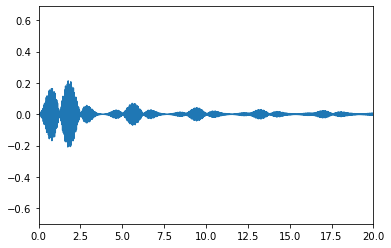

In [79]:
wavelet = np.mean([np.sin(time*100/nu)**2*np.cos(time*nu) for nu in np.arange(120,125,0.1)], axis=0)
plt.plot(time, wavelet)
plt.xlim(0,20)

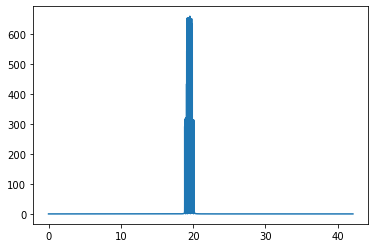

In [80]:
f,p = power_spectrum(wavelet,fr=freq)
plt.plot(f,np.abs(p))
# plt.xlim(15,20)

### Saturation

In [56]:
from matplotlib.colors import LogNorm

In [53]:
Nsatur = np.sum(data == data.max(),0)

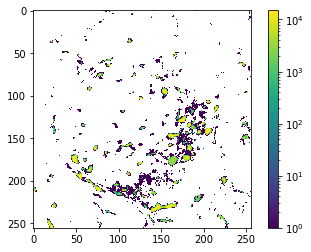

In [66]:
tmp = Nsatur.copy()
tmp[tmp<int(.02*len(data))] = 1
tmp[Nsatur==0] = 0
plt.imshow(tmp, norm=LogNorm())
plt.colorbar()

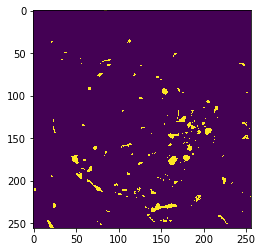

In [71]:
plt.imshow((Nsatur>int(.05*len(data))).astype(int))

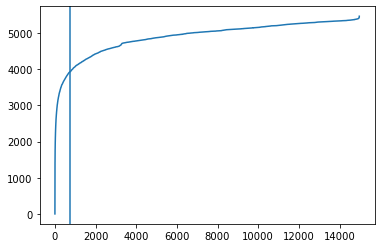

In [80]:
x = sorted(Nsatur[Nsatur>0])
plt.plot(x,np.arange(len(x)))
plt.axvline(int(.05*len(data)))

299

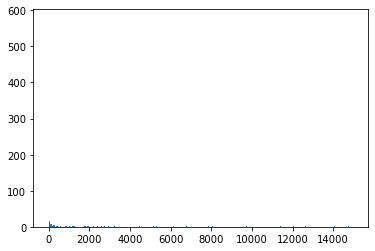

In [63]:
plt.hist(Nsatur[Nsatur>0], np.arange(Nsatur.max())+.5)


### Do regions

In [8]:
from caiman import movie as cmovie

In [9]:
movie = cmovie(data, fr=freq)

In [11]:
from Regions1 import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph

In [12]:
regions = Regions(meanImage,gSig_filt=(4,4,3), mode="mean")
while True:
    peak2bnd = getPeak2BoundaryDF(regions.df)
    df = peak2bnd.query("dist<1.")[["i","j"]]
    if len(df)==0: break
    gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
    dropped = mergeBasedOnGraph(gRois,regions)
    if dropped == 0: break

more than two attractors, not implemented yet, will skip
401 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
6 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
0 subsumed into existing ROIs.


/home/jupyter-srdjan/srdjan_functs/Regions1.py:325: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



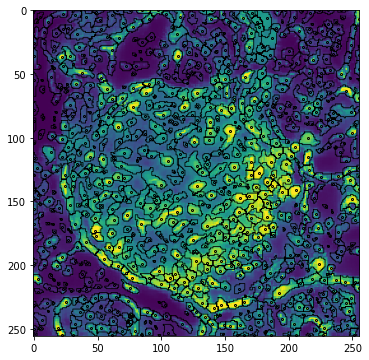

In [13]:
plt.figure(figsize=(6,6))
regions.plotEdges(separate=False)
regions.plotPeaks(ms=2, absMarker=True, color="k")

In [14]:
C = regions.df

In [15]:
regions.update(movie)

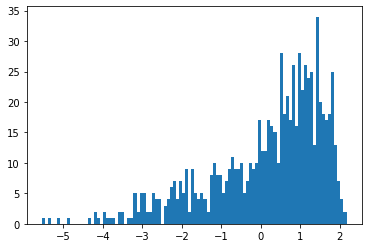

In [22]:
plt.hist(np.log10(C.interest),100);

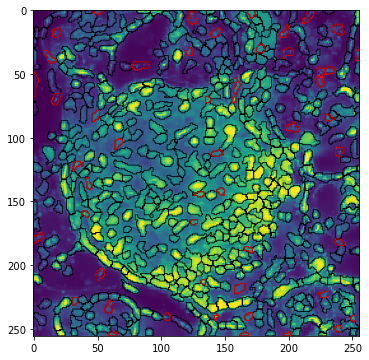

In [626]:
plt.figure(figsize=(6,6))
regions.plotEdges(separate=False)
toDrop = C.query("interest<2").index
regions.plotEdges(ix=toDrop,color="red")

In [639]:
C.drop(index=toDrop, inplace=True)
regions.sortFromCenter()

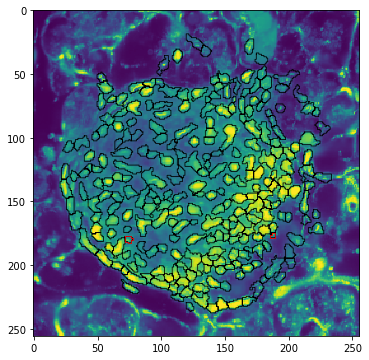

In [638]:
plt.figure(figsize=(6,6))
regions.plotEdges(separate=False)
toDrop = C.query("interest<6").index
toDrop = toDrop[toDrop>140]
regions.plotEdges(ix=toDrop,color="red")

In [29]:
regions.movie.fr

9.9

In [640]:
ts = 40
regions.fast_filter_traces(ts,z_sp=0)

Nrebin = 26


In [641]:
Nrebin = 26
absFast = np.vstack([C.loc[i,"faster_%g"%ts]*C.loc[i,"size"] for i in C.index])*Nrebin
absSlow = np.vstack([C.loc[i,"slower_%g"%ts]*C.loc[i,"size"] for i in C.index])*Nrebin

In [642]:
di = 30
slow_est, fast_vars = [],[]
for i in range(absFast.shape[0]):
    for j in range(di, absFast.shape[1]-di, absFast.shape[1]//30):
        slow_est  += [absSlow[i,j]]
        fast_vars += [absFast[i,j-di:j+di].var()]

In [643]:
fast_vars = np.array(fast_vars)
slow_est = np.array(slow_est)

In [644]:
from sklearn.linear_model import LinearRegression

In [645]:
# logbs = np.percentile(np.log(slow_est),np.linspace(0,100))
logbs = np.log(np.logspace(np.log10(slow_est.min()),np.log10(slow_est.max())))

In [646]:
d = np.digitize(np.log(slow_est), logbs)

In [647]:
x = np.array([slow_est[d==i].mean() for i in np.unique(d)])
y = np.array([np.median(fast_vars[d==i]) for i in np.unique(d)])

In [648]:
# lr = LinearRegression(fit_intercept=False)
# lr.fit(slow_est.reshape(-1,1), (fast_vars))
# gain = lr.coef_[0]

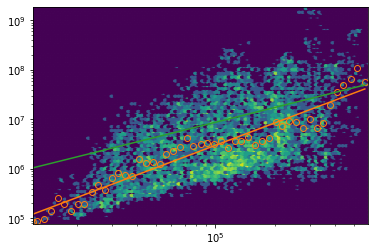

In [649]:
ax = plt.subplot(111)
ax.hexbin(slow_est, fast_vars, bins="log",
          xscale="log",yscale="log"
         )
plt.plot(x,y,"C1o",mfc="none")

lrlog = LinearRegression(fit_intercept=True)
lrlog.fit(np.log(x).reshape(-1,1), np.log(y))
plt.plot(x,np.exp(lrlog.predict(np.log(x).reshape(-1,1))),"C1")


lrlin = LinearRegression(fit_intercept=False)
lrlin.fit(x.reshape(-1,1), y)
plt.plot(x,lrlin.predict(x.reshape(-1,1)),"C2")


# ax.set_aspect("equal")
# ax.plot(slow_est,slow_est,"C1")

In [652]:
regions.fast_filter_traces(ts, meanSlow2Var = lambda xi: np.exp(lrlog.predict(np.log(xi.flatten()).reshape(-1,1))).reshape(xi.shape),
                           z_sp=np.inf)
x = C.loc[i,"slower_%g"%ts].copy()
regions.fast_filter_traces(ts, meanSlow2Var = lambda xi: np.exp(lrlog.predict(np.log(xi.flatten()).reshape(-1,1))).reshape(xi.shape),
                           z_sp=1)
y = C.loc[i,"slower_%g"%ts].copy()

Nrebin = 26
Nrebin = 26
5


In [557]:
%matplotlib notebook

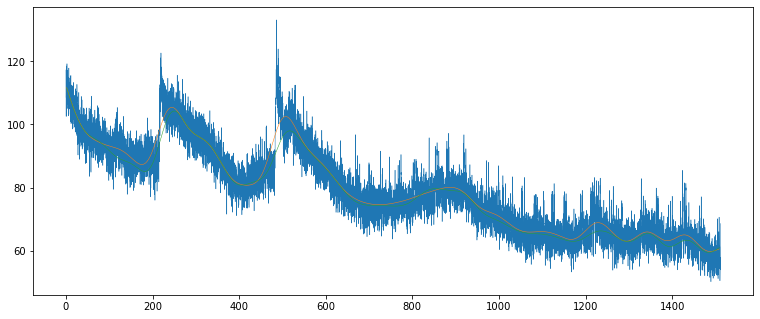

In [653]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.03,.06,1,1])
i = 0
plt.plot(regions.time,C.loc[i,"trace"],lw=.5)
if "%g"%ts in regions.showTime:
    t = regions.showTime["%g"%ts]
else:
    t = regions.time
plt.plot(t,x,"-",lw=.5)
plt.plot(t,y,"-",lw=.5)
# plt.xlim(1050,1070)
# plt.ylim(50,85)

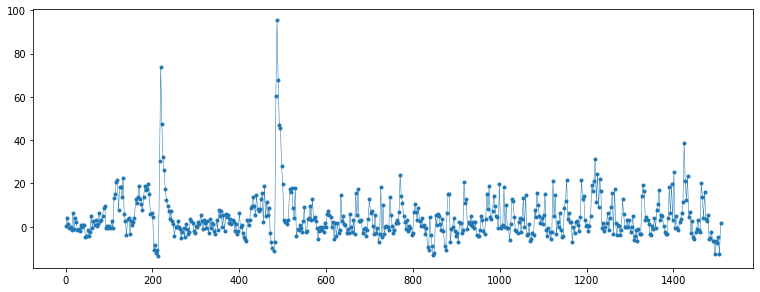

In [613]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.03,.06,1,.9])
plt.plot(t,C.loc[i,"zScore_%g"%ts],".-",lw=.5)
# plt.xlim(1050,1070)

In [655]:
regions.calc_raster(ts)

In [656]:
raster = regions.raster["%g"%ts]

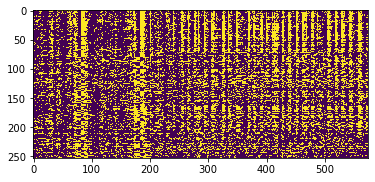

In [657]:
plt.imshow(rebin(raster.T,1).T)

In [658]:
from sklearn.cluster import KMeans

In [688]:
km = KMeans(4)

In [689]:
km.fit(rebin(raster.T,1).T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [690]:
clId = km.predict(rebin(raster.T,1).T)

In [691]:
ii = np.argsort(km.predict(rebin(raster.T,1).T))

In [692]:
from matplotlib.patches import Rectangle

In [693]:
# ax = plt.subplot(111)
# ax.imshow(rebin(raster.T,1).T[ii], cmap="Greys")
# for i in np.unique(clId):
#     ax.add_patch(Rectangle((5,sum(clId<i)+4),raster.shape[1]-10,sum(clId==i)-7, fill=None, lw=2, edgecolor="C%i"%i))

In [694]:
from matplotlib.colors import LogNorm

In [695]:
%matplotlib inline

In [769]:
100*(freq/Nrebin)

38.07692307692308

In [770]:
raster = raster[:,38:]

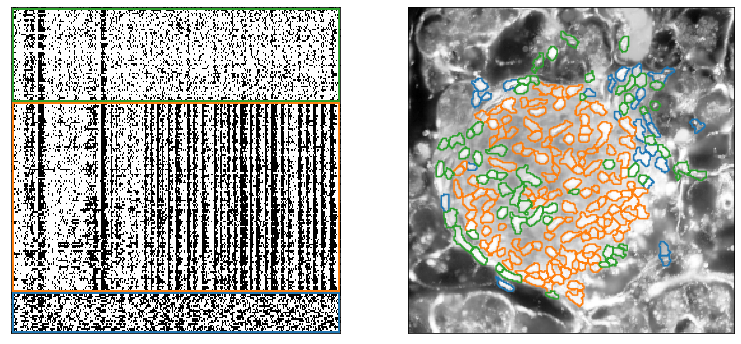

In [772]:
plt.figure(figsize=(13,6))
ax = plt.subplot(121)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(raster[ii,:], cmap="Greys")
# ax.axvline(40)
for i in np.unique(clId)[:3]:
    ax.add_patch(Rectangle((3,sum(clId<i)+.5),raster.shape[1]-6,sum(clId==i)-1, fill=None, lw=2, edgecolor="C%i"%i))
ax.set_aspect("auto")
ax.set_ylim(-.5,sum(clId<=i)+.5)
ax = plt.subplot(122)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(regions.statImages["mean"], norm=LogNorm(), cmap="Greys_r")
# for i in [2]:
for i in np.unique(clId)[:3]:
    ix = C.index[clId==i]
#     ix = ix[ix<300]
    regions.plotEdges(image=False, color="C%i"%i,
                      ix = ix,
                      ax = ax, lw=1.5)

array([ 71,  44,  53, 247])

In [704]:
from numeric import mydebleach

In [710]:
from numeric import sosFilter

In [714]:
representative = np.argmin(km.transform(raster),axis=0)

In [715]:
representative

array([ 71,  44,  53, 247])

In [718]:
# C.loc[53,"trace"]

In [739]:
from general_functions import tally

/home/jupyter-srdjan/srdjan_functs/numeric.py:103: RuntimeWarning:

divide by zero encountered in log

/home/jupyter-srdjan/srdjan_functs/numeric.py:103: RuntimeWarning:

invalid value encountered in log



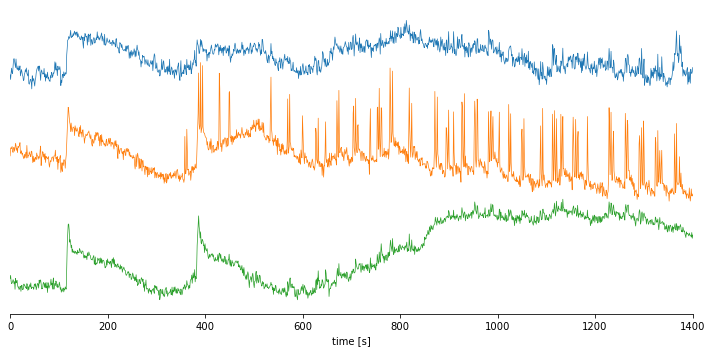

In [752]:
# fig, axs = plt.subplots(4,1,figsize=(15,7), sharex=True)
fig, ax = plt.subplots(1,1,figsize=(10,5))
n = 10
sf = regions.sosFilter#sosFilter(frequency=freq)
ia = 0
# for ax,i in zip(axs,representative):
for i in representative[:3]:
    x = C.loc[i,"trace"]
    xd = mydebleach(x)
    if not np.isnan(xd).any():
        x = x - xd
    else:
        x = x - x.mean()
#     x = sf.run(x)
    x = rebin(x,n)
    t = rebin(regions.time,n)
    ax.plot(t-100,x-30*ia,c="C%i"%ia,lw=.7)

    ia += 1
ax.set_xlabel("time [s]")
plt.yticks([])
plt.xlim(0,1400)
plt.tight_layout()
for sp in ax.spines:
    if sp!="bottom":
        ax.spines[sp].set_visible(False)

In [728]:
np.isnan(C.loc[i,"trace"]).any()

False

In [507]:

for ts in [2,3,4]:
    regions.filter_traces(ts,calcStd=True)

The movie frequency is 9.90, so the filter size is 19. This may take some time.


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/srdj

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 176:
def percFilter(x_,perc,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 176:
def percFilter(x_,perc,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode 

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Functi

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/s

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/home/jup

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back 

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definiti

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more inform

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In defin

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", lin

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecati

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/srdj

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 176:
def percFilter(x_,perc,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 176:
def percFilter(x_,perc,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode 

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/s

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/s

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)




/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of 

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh

The movie frequency is 9.90, so the filter size is 29. This may take some time.


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/srdj

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/srdj

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/s

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)




/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecate

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/srdj

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 176:
def percFilter(x_,perc,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:5

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Functi

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/s

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definiti

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Fun

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_na

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecati

The movie frequency is 9.90, so the filter size is 39. This may take some time.


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/srdj

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 176:
def percFilter(x_,perc,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:5

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/s

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definiti

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 204:
def runningAverage(x_,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more inform

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAver

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/srdj

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Unsupported constraint encountered: raise $12.3

File "srdjan_functs/numeric.py", line 176:
def percFilter(x_,perc,filterSize):
    <source elided>
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
        ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:5

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "percFilter" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 174:
@jit 
def percFilter(x_,perc,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/

/home/jupyter-srdjan/srdjan_functs/numeric.py:173: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: Invalid use of Function(<function nanpercentile at 0x7f67c82380e0>) with argument(s) of type(s): (array(float64, 1d, C), float64, axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanpercentile() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanpercentile at 0x7f67c82380e0>)
[2] During: typing of call at /home/jupyter-srdjan/s

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-whe

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 180:
def percFilter(x_,perc,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
    ^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nan

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)




/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, th

/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of Function(<function nanmean at 0x7f67c8235a70>) with argument(s) of type(s): (array(float64, 1d, C), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
In definition 1:
    TypeError: np_nanmean() got an unexpected keyword argument 'axis'
    raised from /opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/typing/templates.py:517
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function nanmean at 0x7f67c8235a70>)
[2] During: typing of call at /home/jupyter-srdjan/srdjan_functs/numeric.py (209)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True, but has lifted loops.

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 202:
@jit 
def runningAverage(x_,filterSize):
^


/home/jupyter-srdjan/srdjan_functs/numeric.py:201: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runningAverage" failed type inference due to: Invalid use of 

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning:

Function "runningAverage" was compiled in object mode without forceobj=True.

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning:


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "srdjan_functs/numeric.py", line 208:
def runningAverage(x_,filterSize):
    <source elided>
    x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in range(len(out)):
    ^


/opt/tljh

In [ ]:
from numeric import r

In [396]:
regions.calc_peaks(4)

In [397]:
rr = regions.peaks2raster(4,npoints=100)

KeyboardInterrupt: 

In [ ]:
ax = plt.subplot(111)
ax.imshow(rr)
ax.set_aspect("auto")

### Getting Gain from metadata

In [58]:
rec = Recording("/data/Sandra/2019/2019_11_22/Experiment44a.lif")

In [59]:
rec.metadata

,Name,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration,line scan
0,Image005,1,1024,1024,1,0.241,µm,uint8,NaN,2019-11-22 09:39:21,NaT,NaT,none
1,Series007,27781,256,256,1,0.966,µm,uint8,9.86,2019-11-22 09:41:50,2019-11-22 10:28:47,0 days 00:46:57.626001358,none
2,Image012,1,1024,1024,1,0.199,µm,uint8,NaN,2019-11-22 10:43:13,NaT,NaT,none
3,Image022,1,1024,1024,1,0.281,µm,uint8,NaN,2019-11-22 11:02:45,NaT,NaT,none
4,Image025,1,1024,1024,1,0.281,µm,uint8,NaN,2019-11-22 11:03:37,NaT,NaT,none
5,Series028,27545,256,256,1,1.130,µm,uint8,9.86,2019-11-22 11:05:19,2019-11-22 11:51:53,0 days 00:46:34.477001190,none
6,Image038,1,1024,1024,1,0.249,µm,uint8,NaN,2019-11-22 12:24:08,NaT,NaT,none
7,Image041,1,1024,1024,1,0.195,µm,uint8,NaN,2019-11-22 12:28:30,NaT,NaT,none
8,Image043,1,1024,1024,1,0.195,µm,uint8,NaN,2019-11-22 12:29:39,NaT,NaT,none
9,Series046,28080,256,256,1,0.783,µm,uint8,9.86,2019-11-22 12:30:54,2019-11-22 13:18:22,0 days 00:47:28.544000626,none


In [5]:
rec.parse_metadata()

In [33]:
rec.metadata.Frequency.loc[2:] = .5

In [57]:
rec.save_metadata()

In [53]:
rec.metadata.columnsumns

Index(['Name', 'SizeT', 'SizeX', 'SizeY', 'SizeZ', 'pxSize', 'pxUnit',
       'bit depth', 'Frequency', 'Start time', 'End time', 'Duration',
       'line scan'],
      dtype='object')

In [56]:
rec.metadata.loc[2:,"End time"] = rec.metadata.loc[2:,"Start time"]

In [43]:
[int(el.strip("Series")) for el in rec.metadata.Name]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170]

In [51]:
rec.import_series("Series003-170", onlyMeta=True)

In [52]:
rec.Series.keys()

dict_keys(['Series001', 'Series002', 'Series003-5', 'Series003-10', 'Series003-100', 'Series003-170'])

In [44]:
rec.path

'/data/Sandra/2020/2020_11_05/Experiment74a.lif'

In [6]:
# im = rec.xml.image(10)

In [12]:
rec.rdr.rdr.getGlobalMetadata()

<Java object at 0x-249c46e8>

In [19]:
# czi = r"C:\Users\Lee\cpdev\Z-Stack_3slices_dz=1.5um.czi"
# rdr = bioformats.get_image_reader(None, path=czi)
#
#  rdr.rdr is the actual bioformats reader. rdr handles its lifetime
#
# jmd = bf.javabridge.JWrapper(rec.rdr.rdr.getMetadataStore())
jmd = bf.javabridge.JWrapper(rec.rdr.rdr.getSeriesMetadata("",3))

In [20]:
jmd.__dict__.keys()

dict_keys(['o', 'class_wrapper', 'remove', 'get', 'put', 'equals', 'toString', 'values', 'hashCode', 'clone', 'clear', 'isEmpty', 'replace', 'contains', 'replaceAll', 'size', 'entrySet', 'putAll', 'putIfAbsent', 'elements', 'forEach', 'keys', 'keySet', 'containsValue', 'containsKey', 'getOrDefault', 'computeIfAbsent', 'computeIfPresent', 'compute', 'merge', 'wait', 'getClass', 'notify', 'notifyAll', 'field_names', 'methods'])

In [21]:
for t in dir(jmd):
    if "time" in t.lower():
        print (t)
        exec(f"""
try:
    jmd.{t}(0)
except:
    print ("\tnothing")
""")

In [226]:
d_ = rec.xml.Detector(im.node)
i_ = rec.xml.Detector(im.node)

In [230]:
i_.get_Gain()

In [217]:
jmd.getDetectorGain(10,0)

JavaException: Index: 0, Size: 0

In [ ]:
immersion = jmd.getObjectiveImmersion(0,0) # get the first Objective record in the first Instrument record
lensna = jmd.getObjectiveLensNA(0, 0)
magnification = jmd.getObjectiveNominalMagnification(0, 0)
xsize = jmd.getPixelsPhysicalSizeX(0)

In [193]:
rec.xml.root_node.get_namespaces()

AttributeError: 'xml.etree.ElementTree.Element' object has no attribute 'get_namespaces'

In [189]:
dir(im.Pixels)

['Channel',
 'DimensionOrder',
 'ID',
 'PhysicalSizeX',
 'PhysicalSizeXUnit',
 'PhysicalSizeY',
 'PhysicalSizeYUnit',
 'PhysicalSizeZ',
 'PhysicalSizeZUnit',
 'PixelType',
 'Plane',
 'SizeC',
 'SizeT',
 'SizeX',
 'SizeY',
 'SizeZ',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'channel_count',
 'get_DimensionOrder',
 'get_ID',
 'get_PhysicalSizeX',
 'get_PhysicalSizeXUnit',
 'get_PhysicalSizeY',
 'get_PhysicalSizeYUnit',
 'get_PhysicalSizeZ',
 'get_PhysicalSizeZUnit',
 'get_PixelType',
 'get_SizeC',
 'get_SizeT',
 'get_SizeX',
 'get_SizeY',
 'get_SizeZ',
 'get_channel_count',
 'get_plane_count',
 'node',
 'ns',
 'plane_count',
 'set_DimensionOrder',
 'set_ID',
 'set_

In [149]:
printRecur??

In [152]:
from physio_def_0 import omeTag

In [160]:
Levels = np.zeros(5)
level = 0
# printRecur(rec.xml.root_node)
printRecur(rec.xml.OriginalMetadata, )

AttributeError: type object 'OriginalMetadata' has no attribute 'node'

In [142]:
[el for el in rec.xml.root_node.iter_original_metadata(im)]

[]

In [130]:
[el for el in rec.xml.StructuredAnnotations.keys(im)]

['Instrument:10', 'Objective:10:0', 'Pixels:10']

In [114]:
el

'Instrument:0'

In [104]:
for el in rec.xml.StructuredAnnotations.iter_original_metadata():
    break

TypeError: iter_original_metadata() missing 1 required positional argument: 'self'

In [94]:
rec.xml.StructuredAnnotations.__dict__.keys()

dict_keys(['__module__', '__doc__', '__init__', '__getitem__', '__contains__', 'keys', 'has_key', 'add_original_metadata', 'iter_original_metadata', 'has_original_metadata', 'get_original_metadata_value', 'get_original_metadata_refs', 'OriginalMetadata', '__dict__', '__weakref__'])

In [251]:
txt = rec.xml.to_xml()

In [258]:
i = txt.find("Gain")

In [259]:
txt[i-100: i+100]

'ata"><ome:Value><ome:OriginalMetadata><ome:Key>Series054 HardwareSetting|FilterSettingRecord|HyD 2 (Gain) #1</ome:Key><ome:Value>10</ome:Value></ome:OriginalMetadata></ome:Value></ome:XMLAnnotation><o'

In [270]:
i = 0
while True:
    i += txt[i+1:].find("Gain")+1
    k,v = txt[i-100: i+100].split("<ome:Key>")[1].split("</ome:Value>")[0].split("</ome:Key><ome:Value>")
    if ser in k:
        print (k,v)
    if i>len(txt)-100: break

Series041 HardwareSetting|FilterSettingRecord|HyD 2 (Gain) #1 43
Series041 HardwareSetting|FilterSettingRecord|X Reson. Scan Actuator (Gain) #1 1.70000113487319
Series041 HardwareSetting|FilterSettingRecord|Y Reson. Scan Actuator (Gain) #1 1.70000113487319


KeyboardInterrupt: 

In [37]:
# regions.calc_peaks(3)